In [24]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.init as init
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

In [25]:
def  FC_Layer_blockGen(input_dim, output_dim):
    single_block = nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.ReLU()
    )

    return single_block

# Define the Generator
class Generator (nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )
    
    
    def forward(self, x):
        return self.model(x)

# Define a single discriminator block
def FC_Layer_BlockDisc(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.ReLU(),
        nn.Dropout(0.4)
    )

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [26]:
# Define the training parameters
batch_size =  128
num_epochs = 500
lr = 0.0002
num_features = 6
latent_dim = 20

# Model Initialization
generator = Generator(latent_dim, num_features)
discriminator = Discriminator(num_features)

# Loss functions and optimizers
criterion = nn.BCELoss()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr)

In [27]:
# Importing data
file_path = 'SamplingData7.xlsx'
data = pd.read_excel(file_path)
X = data.values
real_data = torch.FloatTensor((X - X.min(axis=0)) / (X.max(axis = 0) - X.min(axis=0)) * 2 - 1)

In [28]:
data.values.astype(float)

array([[ 0.7739981 , -0.81712105,  0.36735052,  1.        , -0.29550349,
         0.76548606],
       [-0.28678859,  0.91689743, -0.04562572, -1.        ,  0.17947916,
         0.96025738],
       [ 0.98845769,  0.77143797,  0.5862555 ,  1.        , -0.2141447 ,
         0.67104518],
       ...,
       [ 0.96397528,  0.94845801,  0.55779921,  1.        , -0.22839044,
         0.68114935],
       [-0.70183677,  0.892462  , -0.11099381, -1.        ,  0.30201741,
         0.79872601],
       [-0.27477518,  0.8305169 , -0.04400394, -1.        ,  0.1728756 ,
         0.96341514]])

In [29]:
# Creating a dataset
class SamplingDataSet(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values.astype(float)
        self.labels = dataframe.values.astype(float)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = {
            'input': torch.tensor(self.data[idx]),
            'label': torch.tensor(self.labels[idx])
        }
        return sample


# Create an instance of the dataset
dataset = SamplingDataSet(data)

# Create a Dataloader
dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)

In [30]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

pretrained = False
if pretrained:
    pre_dict = torch.load('pretrained_model.pth')
    generator.load_state_dict(pretrained['generator'])
    discriminator.load_state_dict(pre_dict['discriminator'])
else:
    generator = generator.apply(weights_init)
    discriminator = discriminator.apply(weights_init)

In [31]:
# Model Training

latent_dim = 20

for epoch in range(num_epochs):
    for i in range(0, real_data.shape[0], batch_size):

        # Train the discriminator on real data
        real_labels = torch.FloatTensor(np.random.uniform(0.9, 1.0, (batch_size, 1)))
        real_data_batch = torch.FloatTensor(real_data[i : (i+batch_size)])
        disc_optimizer.zero_grad()
        output_real = discriminator(real_data_batch)
        loss_real = criterion(output_real, real_labels)
        loss_real.backward()

        disc_optimizer.step()

        # Train the discriminator on generated data (or fake)
        fake_labels = torch.FloatTensor(np.random.uniform(0, 0.1, (batch_size, 1)))
        noise = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))
        generated_data = generator(noise)
        output_fake = discriminator(generated_data.detach())
        loss_fake = criterion(output_fake, fake_labels)

        disc_optimizer.step()

        # Train generator on
        valid_labels = torch.FloatTensor(np.random.uniform(0.9, 1.0, (batch_size, 1)))
        gen_optimizer.zero_grad()
        output_gen = discriminator(generated_data)
        loss_gen = criterion(output_gen, valid_labels)
        loss_gen.backward()

        gen_optimizer.step()
    
    print(f"Epoch {epoch}, D Loss Real {loss_real.item()}, D Loss Fake {loss_fake.item()}, G Loss {loss_gen.item()}")
        

        

Epoch 0, D Loss Real 0.19659236073493958, D Loss Fake 3.3059911727905273, G Loss 0.21777558326721191
Epoch 1, D Loss Real 0.2018924504518509, D Loss Fake 2.880552053451538, G Loss 0.20472663640975952
Epoch 2, D Loss Real 0.20693619549274445, D Loss Fake 2.876568078994751, G Loss 0.19833461940288544
Epoch 3, D Loss Real 0.21227848529815674, D Loss Fake 2.8240151405334473, G Loss 0.21028617024421692
Epoch 4, D Loss Real 0.20165953040122986, D Loss Fake 2.8746235370635986, G Loss 0.20855078101158142
Epoch 5, D Loss Real 0.19638864696025848, D Loss Fake 2.8900599479675293, G Loss 0.212580144405365
Epoch 6, D Loss Real 0.21471668779850006, D Loss Fake 2.940500020980835, G Loss 0.2020805925130844
Epoch 7, D Loss Real 0.202772855758667, D Loss Fake 2.928243637084961, G Loss 0.19779857993125916
Epoch 8, D Loss Real 0.2043624222278595, D Loss Fake 2.9777164459228516, G Loss 0.2006344497203827
Epoch 9, D Loss Real 0.20829445123672485, D Loss Fake 2.948698043823242, G Loss 0.20493075251579285
Epo

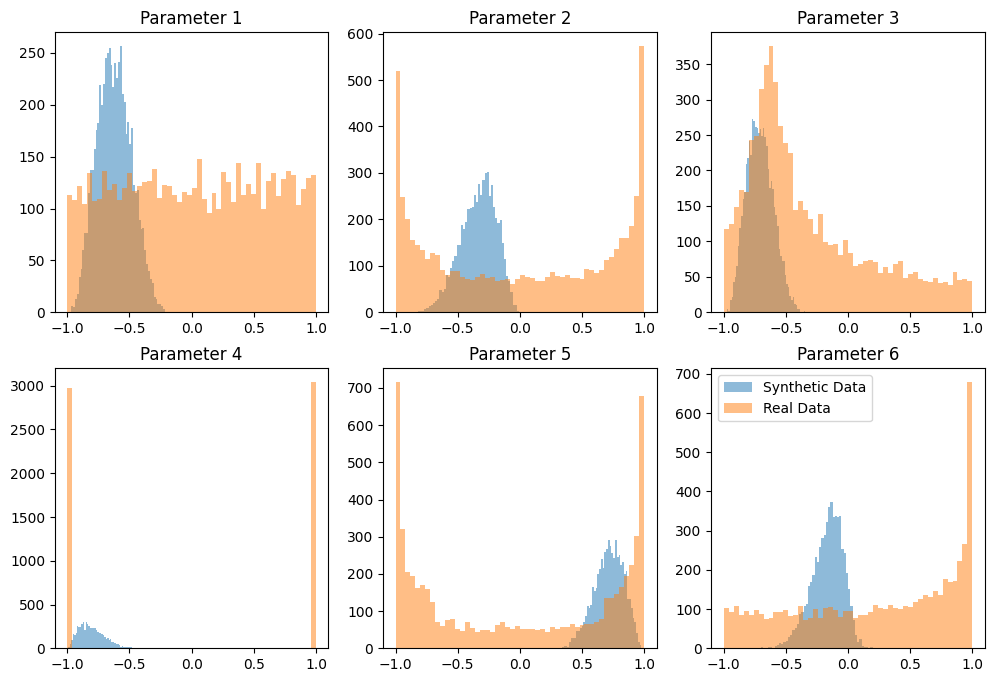

In [32]:
# Generate Synthetic data
synthetic_data = generator(torch.FloatTensor(np.random.normal(0, 1, (real_data.shape[0], latent_dim))))

# Plot the results
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(2):
    for j in range(3):
        axes[i, j].hist(synthetic_data[:, i * 3 + j].detach().numpy(), bins=50, alpha=0.5, label="Synthetic Data")
        axes[i, j].hist(real_data[:, i * 3 + j].numpy(), bins=50, alpha=0.5, label='Real Data')
        axes[i, j].set_title(f'Parameter {i * 3 + j + 1}')

plt.legend()
plt.show()

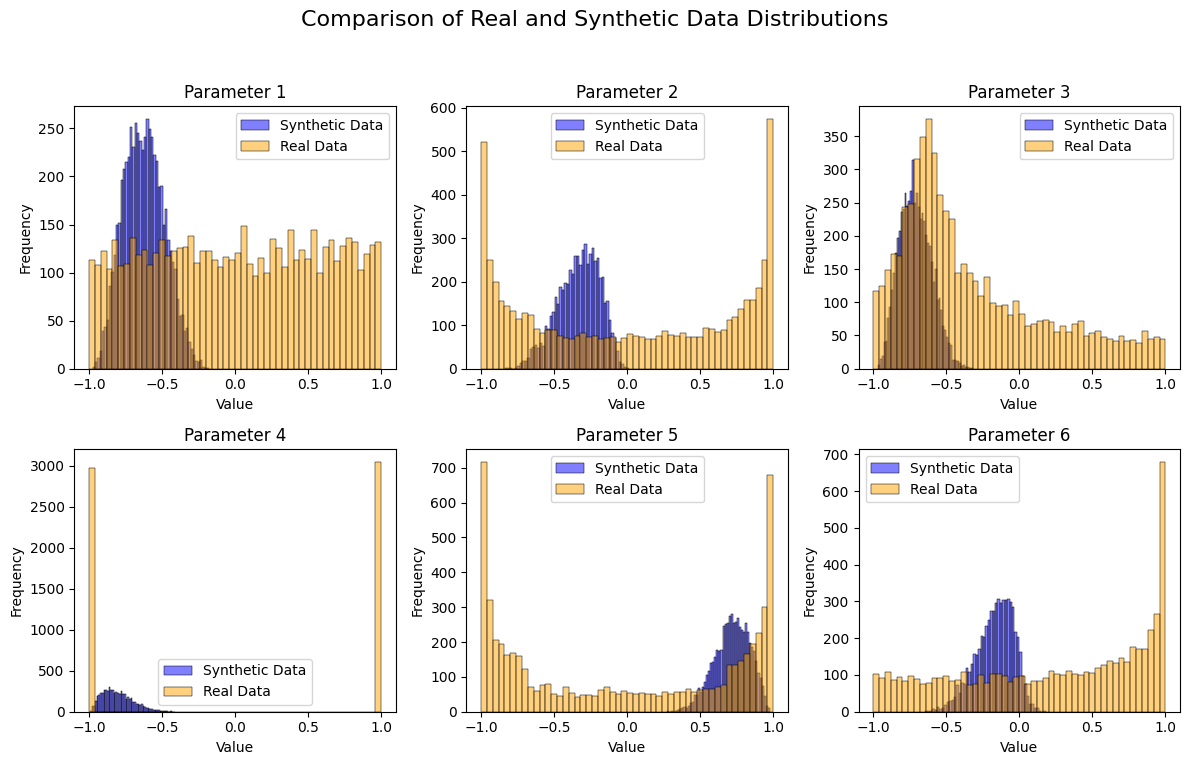

In [33]:
import seaborn as sns

# Generate synthetic data
synthetic_data = generator(torch.FloatTensor(np.random.normal(0, 1, (real_data.shape[0], latent_dim))))

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Comparison of Real and Synthetic Data Distributions', fontsize=16)

for i in range(2):
    for j in range(3):
        sns.histplot(synthetic_data[:, i * 3 + j].detach().numpy(), bins=50, alpha=0.5, label='Synthetic Data', ax=axs[i, j], color='blue')
        sns.histplot(real_data[:, i * 3 + j].numpy(), bins=50, alpha=0.5, label='Real Data', ax=axs[i, j], color='orange')
        axs[i, j].set_title(f'Parameter {i * 3 + j + 1}', fontsize=12)
        axs[i, j].set_xlabel('Value')
        axs[i, j].set_ylabel('Frequency')
        axs[i, j].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()